In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torchvision.datasets as ds
import pylab as plt

In [2]:
def load_mnist(datadir='./data_cache'):
    train_ds = ds.MNIST(root=datadir, train=True,
                           download=True, transform=None)
    test_ds = ds.MNIST(root=datadir, train=False,
                          download=True, transform=None)

    def to_xy(dataset):
        X = np.array(dataset.data) / 255.0  # [0, 1]
        Y = np.array(dataset.targets)
        return X, Y

    X_tr, Y_tr = to_xy(train_ds)
    X_te, Y_te = to_xy(test_ds)
    return X_tr, Y_tr, X_te, Y_te

X_tr, Y_tr, X_te, Y_te = load_mnist()

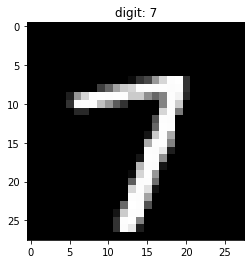

In [3]:
i = np.random.choice(len(X_tr))
plt.imshow(X_tr[i], cmap='gray');
plt.title(f'digit: {Y_tr[i]}');

## Linear Regression

In [4]:
print('original X_tr:', X_tr.shape)

# select 500 random examples
n = 500
I = np.random.choice(len(X_tr), n, replace=False)
X = X_tr[I]
Y = (Y_tr[I] % 2) * 2.0 - 1 # odd/even --> +1/-1
X = X.reshape(-1,  28*28) # flatten

print('reshaped X:', X.shape)
print('reshaped Y:', Y.shape)

original X_tr: (60000, 28, 28)
reshaped X: (500, 784)
reshaped Y: (500,)


Now solve:
$$\text{argmin}_\beta ||X \beta - Y||_2$$
for $\beta \in \mathbb{R}^{784}$

### Stability of Estimates: Normal Equation

In [5]:
print(np.linalg.matrix_rank(X))

500


The rank of the matrix is ultimately constrained by min(n, p) where n is the number of rows and p is the number of columns of the specific matrix. Therefore, here our matrix is not full rank, and furthermore we have more features than data points: p > n: the matrix is going to be singular and it means that there are several solutions to the normal equations. 

In [6]:
Y_test = (Y_te % 2)*2.0 - 1
X_test = X_te.reshape(-1, 28*28)

In [7]:
beta_estimated = np.dot(np.dot(np.linalg.pinv(np.dot(X.T, X)), X.T), Y)
estimated_test_set = np.dot(X_test, beta_estimated)
MSE = np.mean((estimated_test_set - Y_test)**2)


In [8]:
MSE

15.941332824104157

### Stability of Estimates: SGD

In [10]:
from autograd.misc.optimizers import sgd

In [33]:
max_iteration = 50 # convex function, we should converge promptly to the global minima
step_size = 1e-3 # small learning rate
weights_init = np.zeros(X.shape[1])

def make_objective(x_train, y_train):
    
    def objective(W, t):
        forward = np.dot(x_train, W)
        mse = np.mean((forward - y_train)**2)
        return mse
    
    def gradient(W,t):
        return 2*np.dot(x_train.T, np.dot(X, W) - y_train)
    return objective, gradient

objective, gradient = make_objective(X, Y)
weights_track = []
def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective_value = objective(weights, iteration)
            if iteration % 1 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective_value, np.linalg.norm(gradient(weights, iteration))))
            weights_track.append(weights)
            # print(weights)

First, sgd without momentum

In [34]:
sgd(gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back, mass=0)


Iteration 0 lower bound 1.0; gradient mag: 1329.9344784616849
Iteration 1 lower bound 4.737981577105448; gradient mag: 6231.961851475283
Iteration 2 lower bound 849.9011833313708; gradient mag: 174533.66264566235
Iteration 3 lower bound 1077104.2683455385; gradient mag: 6357849.902728046
Iteration 4 lower bound 1437830277.1565504; gradient mag: 232344852.7886074
Iteration 5 lower bound 1920341486570.1016; gradient mag: 8491207224.370295
Iteration 6 lower bound 2564788054728881.0; gradient mag: 310317278857.9738
Iteration 7 lower bound 3.4255043383865994e+18; gradient mag: 11340768315997.479
Iteration 8 lower bound 4.5750680866177003e+21; gradient mag: 414456540977684.6
Iteration 9 lower bound 6.110413512758779e+24; gradient mag: 1.5146612607977556e+16
Iteration 10 lower bound 8.161004949001728e+27; gradient mag: 5.5354386000267725e+17
Iteration 11 lower bound 1.0899753615457152e+31; gradient mag: 2.0229658794157076e+19
Iteration 12 lower bound 1.4557597945361335e+34; gradient mag: 7.39

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.78010838e+71, 1.43305601e+72,
       1.41048820e+71, 1.86133608e+71, 1.50338683e+72, 1.87778812e+72,
       1.55253410e+72, 1.51872759e+72, 2.05536281e+72, 2.08085810e+71,
       2.73873467e+70, 7.94233054e+71, 7.94233054e+71, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

### Spectrum of X

In [37]:
print(X.shape)

(500, 784)


In [50]:
print(np.max(np.linalg.eig(np.dot(X.T, X))[0]))

(18772.859890505562+0j)


In [51]:
print(np.min(np.linalg.eig(np.dot(X.T, X))[0]))

(-2.937279254535514e-14+0j)


In [52]:
print(np.linalg.cond(np.dot(X.T, X)))

inf
